In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import time
% matplotlib inline

In [2]:
pixel = pd.read_table('./pixel.txt', header= None,sep= ' ')
data = pd.read_table('./data.txt', header = None, sep = ' ')

In [3]:
sample = data[:700]

In [4]:
# utility function to cut data points into (memory_length,) windows.
# ex. [1,2,3,4,5], memory_length = 2  -->> [1,2],[2,3],[3,4],[4,5]

memory_length = 40

def data_generator(sample):
    train_X = []
    label = []

    for i in range(len(sample)):
        for j in range(memory_length -1, len(sample.iloc[0])-2):
                temp = np.array(sample.iloc[i, j - memory_length +1: j+1])
                #if np.sum([temp != 0]) != 0:
                train_X.append(np.array(sample.iloc[i, j - memory_length +1: j+1]))
                label.append(sample.iloc[i,j+1])
    return np.array(train_X), np.array(label)


In [5]:
train_X, train_y = data_generator(sample)

In [6]:
len(train_X)

251300

In [7]:
import tensorflow as tf

In [8]:



# each pixel counted as one feature
feature_size = 1

# number of neurals in lstm
hidden_size = 512

# number of possible colors
n_class = 167

batch_size = 1000

n_epoch = 6

In [9]:
# place holders
x = tf.placeholder(tf.float32, [None, memory_length, 1], name = 'x')
y = tf.placeholder(tf.float32, [None, n_class], name = 'y')

In [10]:
# Forward passes

lstm_cell_1 = tf.contrib.rnn.LSTMCell(hidden_size)

multi_lstm_cells =  tf.contrib.rnn.MultiRNNCell([lstm_cell_1],state_is_tuple=True)
output, final_state  = tf.nn.dynamic_rnn(multi_lstm_cells, x, dtype=tf.float32)


In [11]:
# Output fully connected network

shape = output[:,-1,:].get_shape().as_list()
output_layer = { 'weight': tf.Variable(tf.random_normal([shape[-1], n_class], dtype=tf.float32)),
                'bias' : tf.Variable(tf.random_normal([n_class],dtype=tf.float32))}


In [12]:
begin = time.time()

sentiment = tf.matmul(output[:,-1,:], output_layer['weight']) + output_layer['bias']

cost = tf.reduce_sum(tf.nn.softmax_cross_entropy_with_logits(logits = sentiment, labels=y))
    
optimizer = tf.train.AdamOptimizer(learning_rate= 0.02).minimize(cost)
    
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
    
 
    
for epoch in range(n_epoch):
    epoch_loss = 0
        
    # cut into batches
    i = 0
    while i < len(train_X):
        start = i
        end = i + batch_size
        batch_X = train_X[start: end]
        #batch_X = np.array([t for t in batch_X])
        batch_X = batch_X.reshape((-1, memory_length, 1))

            
            
            # the original y is single numeric labels, we transform into one hot 
            # but the out put of tf.one_hot is a tensor node, so we need to sess.run(batch_y)
        batch_y = \
        tf.one_hot(np.array(train_y[start: end]),n_class,on_value=1.0, off_value=0.0)
        #batch_y = train_y[start: end].reshape(-1,1)
            
        _, c = sess.run([optimizer, cost],feed_dict={x: batch_X, y: sess.run(batch_y)})
            
        epoch_loss += c
            
        i += batch_size
    print  ('Epoch:', epoch, 'loss:', epoch_loss)
        

print ('Total time spent:', time.time() - begin)

('Epoch:', 0, 'loss:', 1322274.7886962891)
('Epoch:', 1, 'loss:', 996601.58508300781)
('Epoch:', 2, 'loss:', 989418.36572265625)
('Epoch:', 3, 'loss:', 983563.70556640625)
('Epoch:', 4, 'loss:', 982130.19421386719)
('Epoch:', 5, 'loss:', 978351.37585449219)
('Total time spent:', 14556.14357304573)


In [44]:
# utility function to draw pictures
def draw(image, w, h, pixel):
    """
    pixel: dictionary of pixels
    
    """
    d = np.zeros((h, w, 3), dtype=np.uint8)
    ex = image.reshape((h,w))
    for i in range(h):
        for j in range(w):
            d[i][j][0] = pixel.iloc[ex[i][j]][0]
            d[i][j][1] = pixel.iloc[ex[i][j]][1]
            d[i][j][2] = pixel.iloc[ex[i][j]][2]
    plt.imshow(d, interpolation='nearest')


    plt.figure(figsize=(3,4))

In [14]:
# Utility function to generate predition picture

def generate_pic(image, memory_length, percentage):
    given_length = int(len(image)*percentage)
    predict_image = np.array(image[:given_length])
    

    
    i = 0

    while i < 400 - given_length:
        curr_sentence = predict_image[i: i+ memory_length].astype('float32')
        curr_sentence = curr_sentence.reshape((1, memory_length,1))
        predict_image = np.append(predict_image,np.argmax(sentiment.eval({x: curr_sentence})))

        i += 1
    return predict_image    
    

In [24]:
# Utility function to generate covered picture

def generate_cover(image, memory_length, percentage):
    given_length = int(len(image)*percentage)
    predict_image = np.array(image[:given_length])
    
    # current ending index
    #end = len(predict_image)
    
    i = 0
    #i = given_length - memory_length
    #while i < 400 - memory_length:
    while i < 400 - given_length:

        predict_image = np.append(predict_image,1)
 
        i += 1
    return predict_image    
    

In [80]:
image = data.iloc[783]

predict_image = generate_pic(image, memory_length, 0.6)

cover_image = generate_cover(image, memory_length, 0.6)

/Users/chihchichou/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:8: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


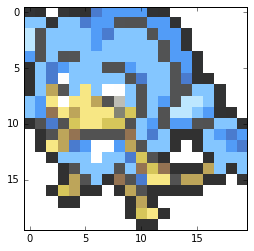

In [81]:
fig1 = plt.gcf()
draw(image, 20,20, pixel)
fig1.savefig('783.png')

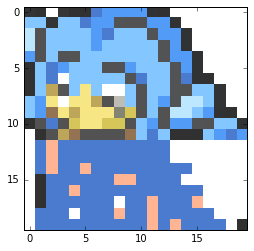

In [82]:
fig1 = plt.gcf()
draw(predict_image, 20,20,pixel)
fig1.savefig('783pred.png')

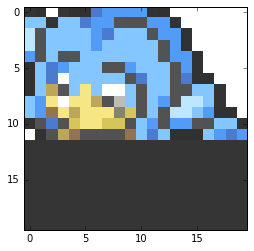

In [83]:
fig1 = plt.gcf()
draw(cover_image, 20,20,pixel)
fig1.savefig('783cover.png')